In [2]:
import math
import numpy as np
import tbplas as tb

In [3]:
# Create primitive cell
def make_empty_cell(algo: int = 0) -> tb.PrimitiveCell:
    """
    Generate lattice vectors of monolayer graphene.
    :param algo: algorithm to generate lattice vectors
    :return: empty primitive cell
    """
    a = 2.46  # cell length a in Angstrom
    b = a  # cell length b in Angstrom
    c = 10.0  # cell length c in Angstrom
    gamma = 60.0  # angle between a1 and a2 in Degrees
    a_half = a * 0.5
    sqrt3 = math.sqrt(3)
    if algo == 0:
        vectors = tb.gen_lattice_vectors(a=a, b=b, c=c, gamma=gamma)
    elif algo == 1:
        vectors = np.array([
            [a, 0, 0,],
            [a_half, sqrt3*a_half, 0],
            [0, 0, c]])
    else:
        vectors = np.array([
            [sqrt3*a_half, -a_half, 0],
            [sqrt3*a_half, a_half, 0],
            [0, 0, c]])
    cell = tb.PrimitiveCell(vectors, unit=tb.ANG)
    return cell 


def add_orbitals(cell: tb.PrimitiveCell, algo: int = 0) -> None:
    """
    Add orbitals to the model.
    :param algo: algorithm to add orbitals
    :return: None. The incoming cell is modified.
    """
    if algo == 0:
        cell.add_orbital((1./3, 1./3),  energy=0.0, label="pz")
        cell.add_orbital((2./3, 2./3),  energy=0.0, label="pz")
    elif algo == 1:
        cell.add_orbital((1./3, 1./3, 0.5), energy=0.0, label="pz")
        cell.add_orbital((2./3, 2./3, 0.5), energy=0.0, label="pz")
    else:
        # NOTE: Tt is assumed that a_1 should be parallel to x-axis
        cell.add_orbital_cart((1.23, 0.71014083), unit=tb.ANG, energy=0.0, label="pz")
        cell.add_orbital_cart((2.46, 1.42028166), unit=tb.ANG, energy=0.0, label="pz") 


def add_hopping_terms(cell: tb.PrimitiveCell, algo: int = 0) -> None:
    """
    Add hopping terms the model.
    :param algo: algorithm to add hopping terms
    :return: None. The incoming cell is modified.
    """
    if algo == 0:
        cell.add_hopping(rn=(0, 0), orb_i=0, orb_j=1, energy=-2.7)
        cell.add_hopping(rn=(1, 0), orb_i=1, orb_j=0, energy=-2.7)
        cell.add_hopping(rn=(0, 1), orb_i=1, orb_j=0, energy=-2.7)
    else:
        cell.add_hopping(rn=(0, 0, 0), orb_i=0, orb_j=1, energy=-2.7)
        cell.add_hopping(rn=(1, 0, 0), orb_i=1, orb_j=0, energy=-2.7)
        cell.add_hopping(rn=(0, 1, 0), orb_i=1, orb_j=0, energy=-2.7)

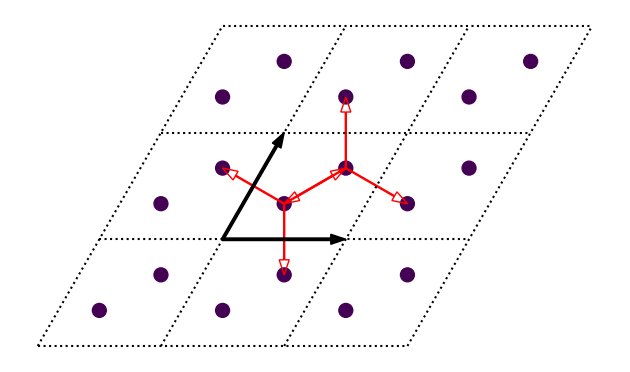

ham[0, 0] = (0.0)
ham[1, 1] = (0.0)
ham[0, 1] = ((-2.7+0j) * exp_i(0.3333333333333333 * ka + 0.3333333333333333 * kb)
 + (-2.7-0j) * exp_i(-0.6666666666666666 * ka + 0.3333333333333333 * kb)
 + (-2.7-0j) * exp_i(0.3333333333333333 * ka - 0.6666666666666666 * kb))
ham[1, 0] = ham[0, 1].conjugate()
with exp_i(x) := cos(2 * pi * x) + 1j * sin(2 * pi * x)


In [14]:
cell = make_empty_cell(algo=0)
add_orbitals(cell, algo=0)
add_hopping_terms(cell, algo=0)
cell.plot()
cell.print_hk()

# Band structure and DOS


Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   

Output details:
  Directory  : ./
  Prefix     : graphene

Using Eigen backend for diagonalization.


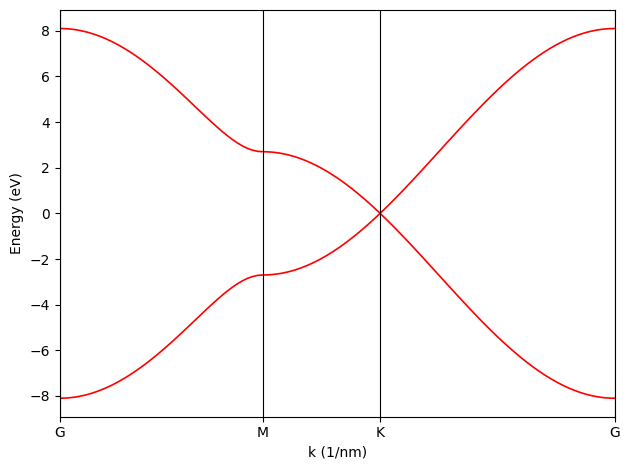

In [21]:
cell = tb.make_graphene_diamond()
k_points = np.array([
    [0.0, 0.0, 0.0],    # Gamma
    [1./2, 0.0, 0.0],   # M
    [2./3, 1./3, 0.0],  # K
    [0.0, 0.0, 0.0],    # Gamma
])
k_label = ["G", "M", "K", "G"]
k_path, k_idx = tb.gen_kpath(k_points, [40, 40, 40])

use_diag_solver = True
if use_diag_solver:
    solver = tb.DiagSolver(cell)
    solver.config.k_points = k_path
    solver.config.prefix = "graphene"
    k_len, bands = solver.calc_bands()
else:
    k_len, bands = tb.calc_bands(cell, k_path, prefix="graphene")

vis = tb.Visualizer()
fig_bands = vis.plot_bands(k_len, bands, k_idx, k_label)


Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   

Output details:
  Directory  : ./
  Prefix     : graphene

Using Eigen backend for diagonalization.


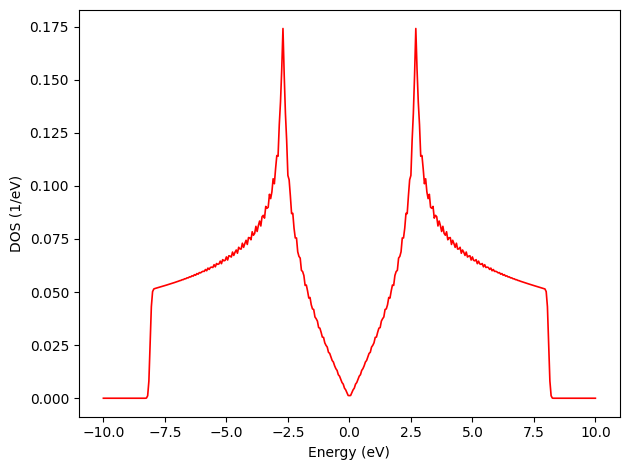

In [ ]:
# DOS
k_mesh = tb.gen_kmesh((120, 120, 1))  # 120*120*1 uniform meshgrid
if use_diag_solver:
    solver = tb.DiagSolver(cell)
    solver.config.k_points = k_mesh
    solver.config.prefix = "graphene"
    solver.config.e_min = -10
    solver.config.e_max = 10
    energies, dos = solver.calc_dos()
else:
    energies, dos = tb.calc_dos(cell, k_mesh, prefix="graphene", e_min=-10, e_max=10)

vis = tb.Visualizer()
fig_dos = vis.plot_dos(energies, dos)